In [1]:
import os

# 查看当前工作目录
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /home/xiaoshan/work/adap_v/DELIVER/semseg


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from schedulers import get_scheduler

In [10]:
import torch
import math
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from ipywidgets import interactive
import pandas as pd
from torch.optim import Adam

# # 定义 PolyLR 等已有的调度器
# class PolyLR(_LRScheduler):
#     def __init__(self, optimizer, max_iter, decay_iter=1, power=0.9, last_epoch=-1) -> None:
#         self.decay_iter = decay_iter
#         self.max_iter = max_iter
#         self.power = power
#         super().__init__(optimizer, last_epoch=-1)

#     def get_lr(self):
#         if self.last_epoch % self.decay_iter or self.last_epoch % self.max_iter:
#             return self.base_lrs
#         else:
#             factor = (1 - self.last_epoch / float(self.max_iter)) ** self.power
#             return [factor * lr for lr in self.base_lrs]


# class WarmupLR(_LRScheduler):
#     def __init__(self, optimizer, warmup_iter=500, warmup_ratio=5e-4, warmup='exp', last_epoch=-1) -> None:
#         self.warmup_iter = warmup_iter
#         self.warmup_ratio = warmup_ratio
#         self.warmup = warmup
#         super().__init__(optimizer, last_epoch)

#     def get_lr(self):
#         ratio = self.get_lr_ratio()
#         return [ratio * lr for lr in self.base_lrs]

#     def get_lr_ratio(self):
#         return self.get_warmup_ratio() if self.last_epoch < self.warmup_iter else self.get_main_ratio()

#     def get_main_ratio(self):
#         raise NotImplementedError

#     def get_warmup_ratio(self):
#         assert self.warmup in ['linear', 'exp']
#         alpha = self.last_epoch / self.warmup_iter

#         return self.warmup_ratio + (1. - self.warmup_ratio) * alpha if self.warmup == 'linear' else self.warmup_ratio ** (1. - alpha)


# class WarmupPolyLR(WarmupLR):
#     def __init__(self, optimizer, power, max_iter, warmup_iter=500, warmup_ratio=5e-4, warmup='exp', last_epoch=-1) -> None:
#         self.power = power
#         self.max_iter = max_iter
#         super().__init__(optimizer, warmup_iter, warmup_ratio, warmup, last_epoch)

#     def get_main_ratio(self):
#         real_iter = self.last_epoch - self.warmup_iter
#         real_max_iter = self.max_iter - self.warmup_iter
#         alpha = real_iter / real_max_iter

#         return (1 - alpha) ** self.power


# class WarmupCosineLR(WarmupLR):
#     def __init__(self, optimizer, max_iter, eta_ratio=0, warmup_iter=500, warmup_ratio=5e-4, warmup='exp', last_epoch=-1) -> None:
#         self.eta_ratio = eta_ratio
#         self.max_iter = max_iter
#         super().__init__(optimizer, warmup_iter, warmup_ratio, warmup, last_epoch)

#     def get_main_ratio(self):
#         real_iter = self.last_epoch - self.warmup_iter
#         real_max_iter = self.max_iter - self.warmup_iter
#         return self.eta_ratio + (1 - self.eta_ratio) * (1 + math.cos(math.pi * real_iter / real_max_iter)) / 2

# # **重启调度器**
# class CosineAnnealingWarmRestarts(_LRScheduler):
#     def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1):
#         self.T_0 = T_0
#         self.T_mult = T_mult
#         self.eta_min = eta_min
#         self.T_i = T_0
#         self.cycle = 0
#         super(CosineAnnealingWarmRestarts, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         if self.last_epoch == 0:
#             self.T_i = self.T_0
#             self.cycle = 0
#         elif self.last_epoch >= self.T_i:
#             self.cycle += 1
#             self.T_i = self.T_0 * (self.T_mult ** self.cycle)
#             self.last_epoch = 0  # 重启

#         return [
#             self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.last_epoch / self.T_i)) / 2
#             for base_lr in self.base_lrs
#         ]

# # 调度器选择函数
# def get_scheduler(scheduler_name: str, optimizer, max_iter: int, power: float, warmup_iter: int, warmup_ratio: float, T_0=10, T_mult=2):
#     if scheduler_name == 'warmuppolylr':
#         return WarmupPolyLR(optimizer, power, max_iter, warmup_iter, warmup_ratio, warmup='linear')
#     elif scheduler_name == 'warmupcosinelr':
#         return WarmupCosineLR(optimizer, max_iter, warmup_iter=warmup_iter, warmup_ratio=warmup_ratio)
#     elif scheduler_name == 'cosineannealingwarmrestarts':
#         return CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)
#     else:
#         raise ValueError(f"Unsupported scheduler: {scheduler_name}")

# 绘制学习率曲线
def plot_lr_scheduler(max_epoch=200, warmup_epoch=10, power=0.9, scheduler_name='warmuppolylr', T_0=10, T_mult=2):
    model_params = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
    optimizer = Adam(model_params, lr=0.0001)
    iters_per_epoch = 74
    scheduler = get_scheduler(scheduler_name, optimizer, int((max_epoch+1)*iters_per_epoch), power, iters_per_epoch *warmup_epoch, warmup_ratio=0.1, T_0=T_0, T_mult=T_mult)
    
    lrs = []
    for epoch in range(max_epoch):
        scheduler.step()
        lr = scheduler.get_lr()
        lr = sum(lr) / len(lr)
        # lrs.append(optimizer.param_groups[0]['lr'])
        lrs.append(lr)
    print(len(lrs))
    print(lrs[0], lrs[-1])
    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_epoch), lrs, label=f'{scheduler_name}')
    plt.title(f'Learning Rate Schedule - {scheduler_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 生成交互式表格
    df = pd.DataFrame({
        'Epoch': range(max_epoch),
        'Learning Rate': lrs
    })
    
    return df

# 创建交互式的widget控件
def interactive_lr_plot(max_epoch=200, warmup_epoch=10, power=0.9, scheduler_name='warmuppolylr', T_0=10, T_mult=2):
    df = plot_lr_scheduler(max_epoch, warmup_epoch, power, scheduler_name, T_0, T_mult)
    return df

# 创建交互式控件
interactive_plot = interactive(interactive_lr_plot, max_epoch=(100, 400, 50), warmup_epoch=(5, 50, 5), power=(0.5, 2.0, 0.05), 
                               scheduler_name=['warmuppolylr', 'warmupcosinelr', 'cosineannealingwarmrestarts'], T_0=(10, 50, 5), T_mult=(1, 5, 1))
interactive_plot


interactive(children=(IntSlider(value=200, description='max_epoch', max=400, min=100, step=50), IntSlider(valu…

In [31]:
ckpt_path = '/home/xiaoshan/work/adap_v/DELIVER/output/DSEC_CMNeXt-B2_i/model_day_11_CMNeXt_CMNeXt-B2_DSEC_epoch220_73.99_checkpoint.pth'
ckpt = torch.load(ckpt_path)

/tmp/ipykernel_2115636/4231719929.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


In [35]:
# ckpt.keys() # dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'scheduler_state_dict', 'best_miou'])
ckpt['loss'], ckpt['scheduler_state_dict'], ckpt['epoch'], ckpt['best_miou']

(0.7825905724366506,
 {'power': 0.95,
  'max_iter': 29674,
  'warmup_iter': 740,
  'warmup_ratio': 0.1,
  'warmup': 'linear',
  'base_lrs': [0.0001, 0.0001],
  'last_epoch': 16500,
  'verbose': False,
  '_step_count': 16501,
  '_get_lr_called_within_step': False,
  '_last_lr': [4.7358040313245604e-05, 4.7358040313245604e-05]},
 220,
 73.99)

In [118]:
scheduler_name = 'warmuppolylr'
max_epoch=400
power=0.95
warmup_epoch=10
model_params = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = Adam(model_params, lr=0.0001)
iters_per_epoch = 74
scheduler = get_scheduler(scheduler_name, optimizer, int((max_epoch+1)*iters_per_epoch), power, iters_per_epoch *warmup_epoch, warmup_ratio=0.1)

In [119]:
# cur_epoch = 396 - 1 # start 1
# cur_iter = 49   # start 1
iters_per_epoch = 74
power = 0.95
lr_base = 1e-4
ratios = {}
lrs = {}
lr2s = {}
xs = {}
warmup_ratio = 0.1
warmup_iter = warmup_epoch * iters_per_epoch
assert warmup_iter == 740
max_iter = (max_epoch+1)*iters_per_epoch
assert max_iter == 29674
for cur_epoch in range(max_epoch+1):
    ratios[cur_epoch] = []
    lrs[cur_epoch] = []
    lr2s[cur_epoch] = []
    xs[cur_epoch] = []
    for cur_iter in range(iters_per_epoch+1):
        x = cur_epoch * (iters_per_epoch+1) + cur_iter + 1
        xs[cur_epoch].append(x)
        if x < warmup_iter:
            alpha = x / warmup_iter
            ratio = warmup_ratio + (1. - warmup_ratio) * alpha
            # ratio = warmup_ratio ** (1. - alpha)
        else:
            real_iter = x - warmup_iter
            real_max_iter = max_iter - warmup_iter
            alpha = real_iter / real_max_iter
            ratio = (1 - alpha) ** power
        ratios[cur_epoch].append(ratio)
        lr = ratio * lr_base
        lrs[cur_epoch].append(lr)
        scheduler.step()
        lr2 = scheduler.get_lr()
        lr2 = sum(lr2) / len(lr2)
        lr2s[cur_epoch].append(lr2)
        # print(cur_epoch, cur_iter, lr, lr2)
        if abs(lr - lr2) > 1e-6:
            print(cur_epoch, cur_iter, lr, lr2)
            break

/home/xiaoshan/miniconda3/envs/cmnext/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [121]:
lrs[219][-1], lrs[395][48], xs[395][48], lr2s[395][48]

(4.7358040313245604e-05, 0.0, 29674, 0.0)

In [15]:
import torch
import torch.nn as nn
from torchviz import make_dot

# 定义 Basic 块
class Basic(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Basic, self).__init__()
        self.netMain = nn.Sequential(
            nn.PReLU(num_parameters=out_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(num_parameters=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.netMain(x)

# 定义 Downsample 块
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.netMain = nn.Sequential(
            nn.PReLU(num_parameters=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.PReLU(num_parameters=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.netMain(x)

# 定义 Upsample 块
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.netMain = nn.Sequential(
            nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=False),
            nn.PReLU(num_parameters=in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(num_parameters=out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.netMain(x)

# 定义 Softmetric 网络
class Softmetric(nn.Module):
    def __init__(self):
        super(Softmetric, self).__init__()
        self.netEventInput = nn.Conv2d(5, 8, kernel_size=3, stride=1, padding=1, bias=False)
        self.netFlow = nn.Conv2d(2, 8, kernel_size=3, stride=1, padding=1, bias=False)

        self.basic0x0 = Basic(16, 16)
        self.basic1x0 = Basic(32, 32)
        self.basic2x0 = Basic(64, 64)
        self.basic3x0 = Basic(96, 96)

        self.down0x0 = Downsample(16, 32)
        self.down1x0 = Downsample(32, 64)
        self.down2x0 = Downsample(64, 96)

        self.up3x1 = Upsample(96, 64)
        self.up2x1 = Upsample(64, 32)
        self.up1x1 = Upsample(32, 16)

        self.netOutput = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PReLU(num_parameters=16),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)
        )

        self.netShortcut = nn.Conv2d(16, 1, kernel_size=1, stride=1, bias=False)

    def forward(self, x, flow):
        event_feat = self.netEventInput(x)
        flow_feat = self.netFlow(flow)

        out = torch.cat([event_feat, flow_feat], dim=1)

        out = self.basic0x0(out)
        out = self.down0x0(out)
        out = self.basic1x0(out)
        out = self.down1x0(out)
        out = self.basic2x0(out)
        out = self.down2x0(out)
        out = self.basic3x0(out)

        out = self.up3x1(out)
        out = self.basic2x0(out)
        out = self.up2x1(out)
        out = self.basic1x0(out)
        out = self.up1x1(out)
        out = self.netOutput(out) + self.netShortcut(out)
        return out

# 模拟输入数据
model = Softmetric()
x = torch.randn(1, 5, 64, 64)  # 模拟输入
flow = torch.randn(1, 2, 64, 64)  # 模拟输入

# 生成网络的计算图
y = model(x, flow)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("Softmetric_Network", format="png")


'Softmetric_Network.png'

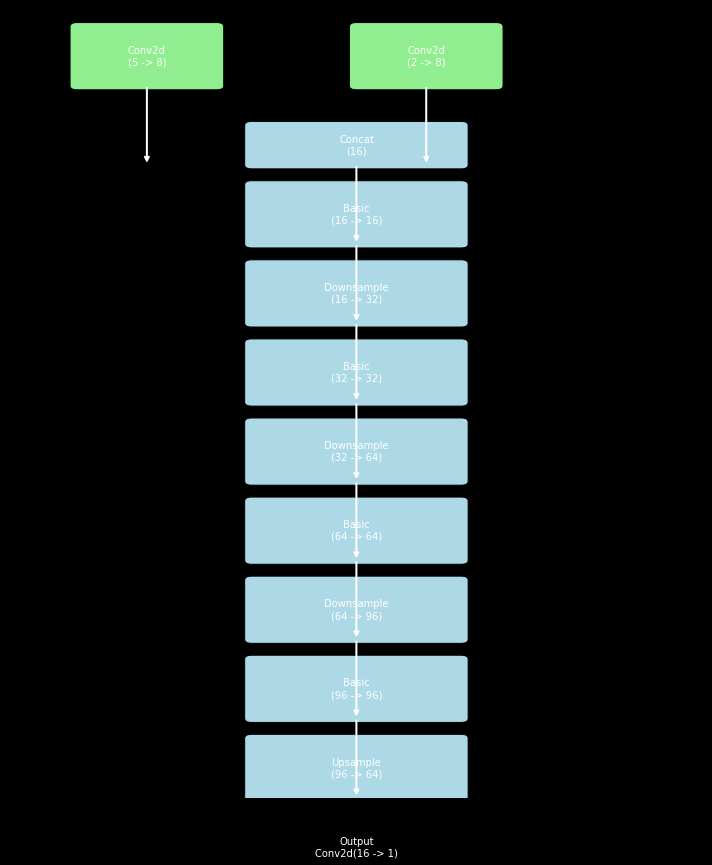

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Helper function to draw a layer block
def draw_block(ax, text, position, width=1, height=1, color='lightblue'):
    x, y = position
    block = patches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.1", edgecolor='black', facecolor=color)
    ax.add_patch(block)
    ax.text(x + width / 2, y + height / 2, text, ha='center', va='center', fontsize=10)

# Helper function to draw arrows between layers
def draw_arrow(ax, start, end):
    ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=2))

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 12))
ax.set_xlim(0, 10)
ax.set_ylim(0, 20)

# Hide axes
ax.axis('off')

# Drawing the Softmetric network layers
draw_block(ax, 'Conv2d\n(5 -> 8)', (1, 18), width=2, height=1.5, color='lightgreen')  # netEventInput
draw_block(ax, 'Conv2d\n(2 -> 8)', (5, 18), width=2, height=1.5, color='lightgreen')  # netFlow

# Connecting the initial convolutions
draw_arrow(ax, (2, 18), (2, 16))
draw_arrow(ax, (6, 18), (6, 16))

# Concatenation of event and flow features
draw_block(ax, 'Concat\n(16)', (3.5, 16), width=3, height=1)

# Layer (0x0 - 0x1) Basic
draw_arrow(ax, (5, 16), (5, 14))
draw_block(ax, 'Basic\n(16 -> 16)', (3.5, 14), width=3, height=1.5)

# Layer (0x0 - 1x0) Downsample
draw_arrow(ax, (5, 14), (5, 12))
draw_block(ax, 'Downsample\n(16 -> 32)', (3.5, 12), width=3, height=1.5)

# Layer (1x0 - 1x1) Basic
draw_arrow(ax, (5, 12), (5, 10))
draw_block(ax, 'Basic\n(32 -> 32)', (3.5, 10), width=3, height=1.5)

# Layer (1x0 - 2x0) Downsample
draw_arrow(ax, (5, 10), (5, 8))
draw_block(ax, 'Downsample\n(32 -> 64)', (3.5, 8), width=3, height=1.5)

# Layer (2x0 - 2x1) Basic
draw_arrow(ax, (5, 8), (5, 6))
draw_block(ax, 'Basic\n(64 -> 64)', (3.5, 6), width=3, height=1.5)

# Layer (2x0 - 3x0) Downsample
draw_arrow(ax, (5, 6), (5, 4))
draw_block(ax, 'Downsample\n(64 -> 96)', (3.5, 4), width=3, height=1.5)

# Layer (3x0 - 3x1) Basic
draw_arrow(ax, (5, 4), (5, 2))
draw_block(ax, 'Basic\n(96 -> 96)', (3.5, 2), width=3, height=1.5)

# Upsample branch
draw_arrow(ax, (5, 2), (5, 0))
draw_block(ax, 'Upsample\n(96 -> 64)', (3.5, 0), width=3, height=1.5)

# Final Output layer
draw_arrow(ax, (5, 0), (5, -2))
draw_block(ax, 'Output\nConv2d(16 -> 1)', (3.5, -2), width=3, height=1.5)

# Show the plot
plt.tight_layout()
plt.show()
